(labs:cor4)=
# Segmentation

<hr>

## 📌 Commentaires pour les intervenants

- Vérifier au début de la séance que les étudiants ont compris qu'il faut calculer le Dice pour chacune des 3 méthodes de segmentation.
- Je ne sais pas si les étudiants se souviennne comment seuiller l'image (même si on l'a fait dans des Labs précédents) :
  vérifier cela et éventuellement donner l'instruction au tableau.
- La notion de vérité terrain est difficile pour les étudiants : pourquoi segmenter si on a la vérité terrain ?
  Ou : comment peut-on avoir une vérité terrain alors qu'on n'arrive pas à segmenter ?
  Ou : comment fabriquer une vérité terrain ?
  etc.
  Ce point est critique et il faut faire attention à l'expliquer, à la fois à tout le groupe, mais aussi en individuel.
- Faire comprendre aux étudiants qu'un Dice tout seul n'est pas hyper informatif, c'est le plus souvent utilisé avec d'autres Dice pour comparer les méthodes.
- Seuillage local : plutôt que de leur demander de le coder, j'ai choisi d'utiliser la fonction déjà existante.
  Mais j'aimerais que les étudiants aient tout de même compris comment fonctionne la méthode.
  Là aussi, il faudra passer du temps auprès de quelques étudiants ou groupes que le fonctionnement est bien compris
  (par exemple en leur demandant de l'expliquer).
  
<hr>

The objectives of this exercise are:
* to apply and compare several segmentation methods
* to evaluate the results of these methods through the Dice coefficient

In [1]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_local
from scipy.spatial.distance import dice

The image is:

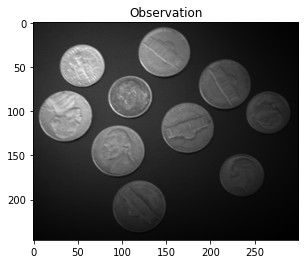

In [2]:
img = io.imread('observation.png')
plt.imshow(img, cmap='gray')
plt.title("Observation")
plt.show()

To evaluate the performance of a segmentation method, we can compare the segmentation with the ground truth,
_i.e._ the optimal segmentation, shown below.

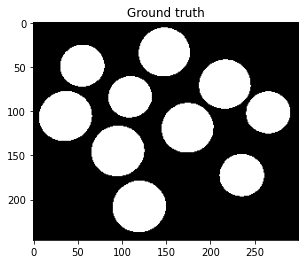

In [3]:
gt = io.imread('groundtruth.png')
plt.imshow(gt, cmap='gray')
plt.title('Ground truth')
plt.show()

In [4]:
segmentations = []

## Binary thresholding

Unfortunately, the image histogram does not show two clear modes.
We choose here to set the threshold to 90.

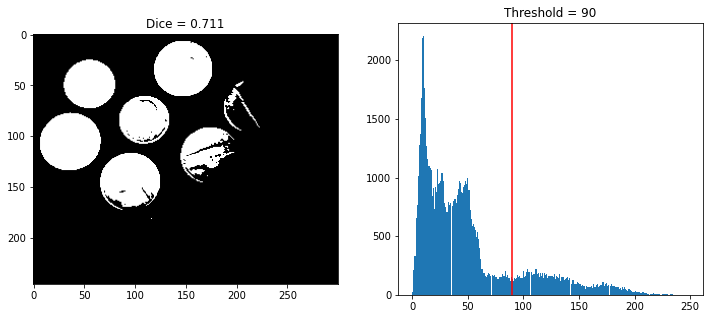

In [5]:
threshold = 90
binarized = img > threshold

# Saving
segmentations.append(["Binary thresholding", threshold, binarized])

# Dice similarity coefficient
f = binarized.ravel().astype(bool)
g = gt.ravel().astype(bool)
d = 1 - dice(f,g)
    
# Display
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.imshow(binarized, cmap='gray')
ax1.set_title(f'Dice = {d:.3f}')
ax2.hist(img.ravel(), bins=256)
ax2.axvline(threshold, color='r')
ax2.set_title(f"Threshold = {threshold}")
plt.show()    

With this threshold, the Dice coefficient equals 0.711, which is not very satisfying
(recall that the Dice coefficient ranges between 0 and 1, 1 being the best value.
This can be explained by the fact that the lighting of the image is not constant.
Indeed, some coins are lighter than certain zones of the background, but other coins are darker,
so it is impossible to choose a threshold to separate the coins from the background.

## Otsu's method

Manual thresholding has the disadvantage of being, precisely, manual.
On the contrary, Otsu's method _automatically_ calculates a threshold value.
However, for the considered image, the segmentation is still not very satisfying.

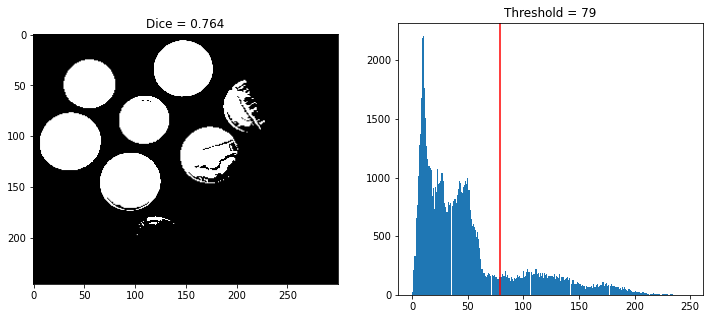

In [6]:
threshold = threshold_otsu(img, nbins=256)
binarized = img > threshold

# Saving
segmentations.append(["Otsu's method", threshold, binarized])

# Dice similarity coefficient
f = binarized.ravel().astype(bool)
g = gt.ravel().astype(bool)
d = 1 - dice(f,g)
    
# Display
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.imshow(binarized, cmap='gray')
ax1.set_title(f'Dice = {d:.3f}')
ax2.hist(img.ravel(), bins=256)
ax2.axvline(threshold, color='r')
ax2.set_title(f"Threshold = {threshold}")
plt.show()  

Otsu's method finds a lower threshold than the one set manually above.
As a result, there are more white pixels in the segmentation.

## A method that optimizes the Dice coefficient (knowing the ground truth)

A small remark before continuing.

The simplest method for finding the best threshold in the sense of the Dice coefficient consists in testing all the threshold values (from 0 to 255)
and calculating the Dice coefficient for each one.
Of course, this method cannot be used in a real case since it requires knowing the ground truth!
However, it has the interest of discussing the Otsu's threshold.

The graph below represents the Dice coefficient as a function of the threshold value.
The best threshold corresponds to the red line.

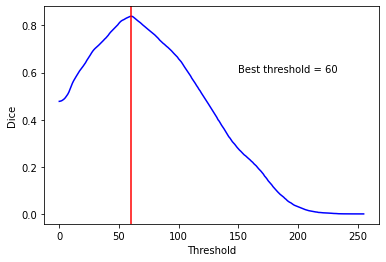

In [7]:
thresholds = range(0,256)
dices = []

for t in thresholds:
    
    # Thresholding
    binarized = img > t
    
    # Dice similarity coefficient
    f = binarized.ravel().astype(bool)
    g = gt.ravel().astype(bool)
    d = 1 - dice(f,g)
    dices.append(d)

# Meilleur seuil
threshold = thresholds[np.argmax(dices)]

# Affichage
plt.figure()
plt.plot(thresholds, dices,'b-')
plt.axvline(threshold, color='r')
plt.xlabel('Threshold');
plt.ylabel('Dice');
plt.text(150, .6, f"Best threshold = {threshold}")
plt.show()

The threshold that maximizes the Dice equals 60, which gives the result below.

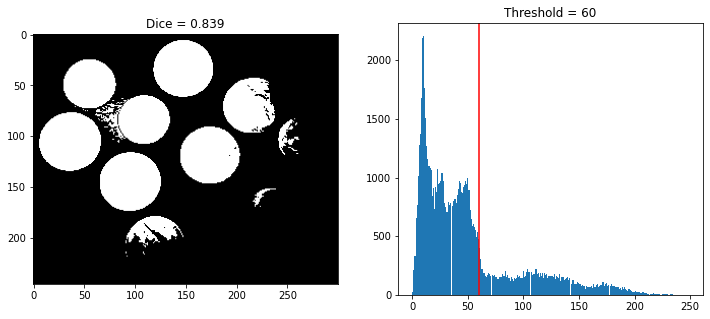

In [8]:
binarized = img > threshold

# Saving
segmentations.append(["Dice optimization", threshold, binarized])

# Dice similarity coefficient
f = binarized.ravel().astype(bool)
g = gt.ravel().astype(bool)
d = 1 - dice(f,g)
    
# Display
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.imshow(binarized, cmap='gray')
ax1.set_title(f'Dice = {d:.3f}')
ax2.hist(img.ravel(), bins=256)
ax2.axvline(threshold, color='r')
ax2.set_title(f"Threshold = {threshold}")
plt.show()  

Then, Otsu's threshold is not the best, in the sense of Dice coefficient.

## Local thresholding

The idea of local thresholding is to define a threshold $T_{m,n}$ for each pixel $(m,n)$ of the image.
Besides, the thresholding is done as usual:

$$
\begin{split}
  g(m,n) =
  \begin{cases}
    1 & \text{if}\, f(m,n)\geqslant T_{m,n}, \\
    0 & \text{if}\, f(m,n)<T_{m,n}
  \end{cases}
\end{split}
$$

There are numerous ways to define the threshold $T_{m,n}$ for a particular pixel.
The simplest way is to define $T_{m,n}$ as the mean of the intensities of a sub-image of size $B\times B$ centered on the pixel $(m,n)$.
It is also possible to compute a weighted mean, such as the default option of `skimage.filters.threshold_local`.

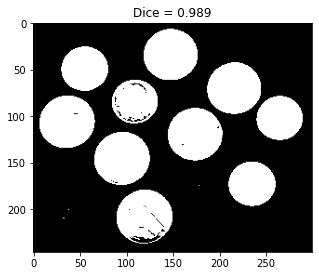

In [9]:
thresholds = threshold_local(img, 151)
binarized = img > thresholds

# Saving
segmentations.append(["Local thresholding", "(multiple thresholds)", binarized])

# Dice similarity coefficient
f = binarized.ravel().astype(bool)
g = gt.ravel().astype(bool)
d = 1 - dice(f,g)
    
# Display
fig, ax1 = plt.subplots(1,1, figsize=(5,5))
ax1.imshow(binarized, cmap='gray')
ax1.set_title(f'Dice = {d:.3f}')
plt.show()  

As you can see, the Dice coefficient is now very good!
Of course, it depends on the size of the sub-images.
In this example, how can you find the best size?

## Comparison

The four previous results are presented below to ease a visual comparison.

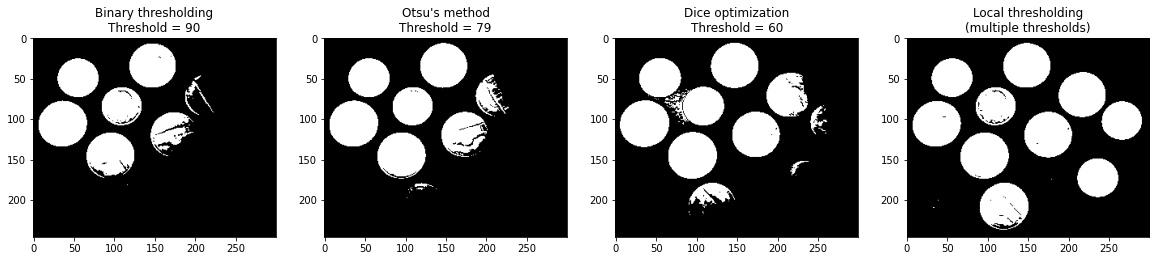

In [10]:
N = len(segmentations)
fig, axs = plt.subplots(1,N,figsize=(20,5))
for i, s in enumerate(segmentations):
    axs[i].imshow(s[2], cmap="gray")
    if type(s[1])!=str:
        axs[i].set_title(f"{s[0]}\nThreshold = {s[1]}")
    else:
        axs[i].set_title(f"{s[0]}\n{s[1]}")
plt.show()